In [1]:
import pandas as pd

import numpy as np
from rdkit import Chem
import torch
from torch.utils.data import Dataset

In [2]:
from pom_models.functions import fragance_propabilities_from_smiles

from numpy.linalg import norm

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


### Define dataset

In [3]:
class OpenPOMDataset(Dataset):
    def __init__(self, openpom_file="openpomdata.csv", train=True, split_seed=142857, ratio=0.9):
        df = pd.read_csv(openpom_file).drop("descriptors",axis=1)
        df =  df[df['odorless'] == False]
        df = df[df["nonStereoSMILES"].apply(self.explicit_H_filter)].copy()  
        self.df = df.reset_index(drop=True)
        rng = np.random.default_rng(split_seed)
        idcs = np.arange(len(self.df))
        rng.shuffle(idcs)
        if train:
            self.idcs = idcs[: int(np.floor(ratio * len(self.df)))]
        else:
            self.idcs = idcs[int(np.floor(ratio * len(self.df))) :]
        self.obj_to_graph = lambda x: x
        self.targets = self.df.keys()[1:]

    def setup(self, task, ctx):
        self.obj_to_graph = ctx.obj_to_graph


    def __len__(self):
        return len(self.idcs)

    def __getitem__(self, idx):
        # Returns the RDkit mol object and corresponding 138 scent labels
        m_smiles = self.df["nonStereoSMILES"][self.idcs[idx]]
        return (
            self.obj_to_graph(Chem.MolFromSmiles(m_smiles)),
            #torch.tensor([self.df[t][self.idcs[idx]] for t in self.targets]).float(),
            torch.tensor([self.df['vanilla'][self.idcs[idx]]]).float(),
            #torch.tensor([self.compute_reward_from_smiles(m_smiles)]).float()
        )
    
    def compute_reward_from_smiles(self, m_smiles):
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            return self.cosine_similarity(TARGET_VEC,m_vec)
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    
    def explicit_H_filter(self, smiles: str) -> bool:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetNumExplicitHs() > 1:
                return False  
        return True



In [4]:
from gflownet import GFNTask,LogScalar,ObjectProperties
from gflownet.config import Config,init_empty
from typing import Dict, List, Tuple
from torch import Tensor


In [5]:
class ScentTask(GFNTask):
    def __init__(self, dataset: Dataset, cfg: Config):
        self.dataset = dataset
        self.num_cond_dim = 1
        self.num_objectives = 138

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return {"encoding": torch.ones(n, 1)}

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        #print(obj_props)
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        #print(scalar_logreward)
        return LogScalar(scalar_logreward.flatten())
    
    def compute_obj_properties(self, mols):
        is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 for m in mols ]).bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,1))), is_valid
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        
        rs = torch.tensor(self.compute_reward_from_mols(valid_mols)).float()
        return ObjectProperties(rs.reshape((-1, 1))), is_valid 
    
        #Attempt for multible scents
        #flat_r = []
        #for m in mols:
        #    flat_r.append(torch.tensor(fragance_propabilities_from_smiles(Chem.MolToSmiles(m))[0]).float())
        #flat_rewards = torch.stack(flat_r, dim=0)
        #return ObjectProperties(flat_rewards), is_valid
    
    def compute_reward_from_mols(self, mols):
        rewards = []
        for m in mols:
            m_smiles = Chem.MolToSmiles(m)
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            rewards.append(self.cosine_similarity(TARGET_VEC,m_vec))
        return rewards
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

In [6]:
from gflownet.online_trainer import StandardOnlineTrainer
import socket
from gflownet.envs.mol_building_env import MolBuildingEnvContext

In [7]:
class ScentTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.valid_random_action_prob = 0.0
        cfg.num_workers = 8
        cfg.num_training_steps = 100000
        cfg.opt.learning_rate = 1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20000
        cfg.opt.clip_grad_type = "norm"
        cfg.opt.clip_grad_param = 10
        cfg.algo.num_from_policy = 32
        cfg.algo.num_from_dataset = 32
        cfg.algo.train_random_action_prob = 0.001
        cfg.algo.illegal_action_logreward = -75
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #["C", "N", "F", "O"],
            #charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            expl_H_range=[0,1],
            num_cond_dim=self.task.num_cond_dim,
            max_nodes=self.cfg.algo.max_nodes,
        )

    def setup_data(self):
        self.training_data = OpenPOMDataset(train=True)
        self.test_data = OpenPOMDataset(train=False)

    def setup_task(self):
        self.task = ScentTask(dataset=self.training_data,cfg=self.cfg)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task,self.ctx)
        self.test_data.setup(self.task,self.ctx)




In [8]:
import pathlib

In [9]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )


In [ ]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/dataload_1"


# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 

config.num_training_steps = 400 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1

config.overwrite_existing_exp=True



trial = ScentTrainer(config)
trial.run()
save_run(trial)



Hyperparameters:

desc: noDesc
log_dir: ./logs/dataload_1
device: cpu
seed: 1
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 400
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: e7c59a8
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr_dec

In [11]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

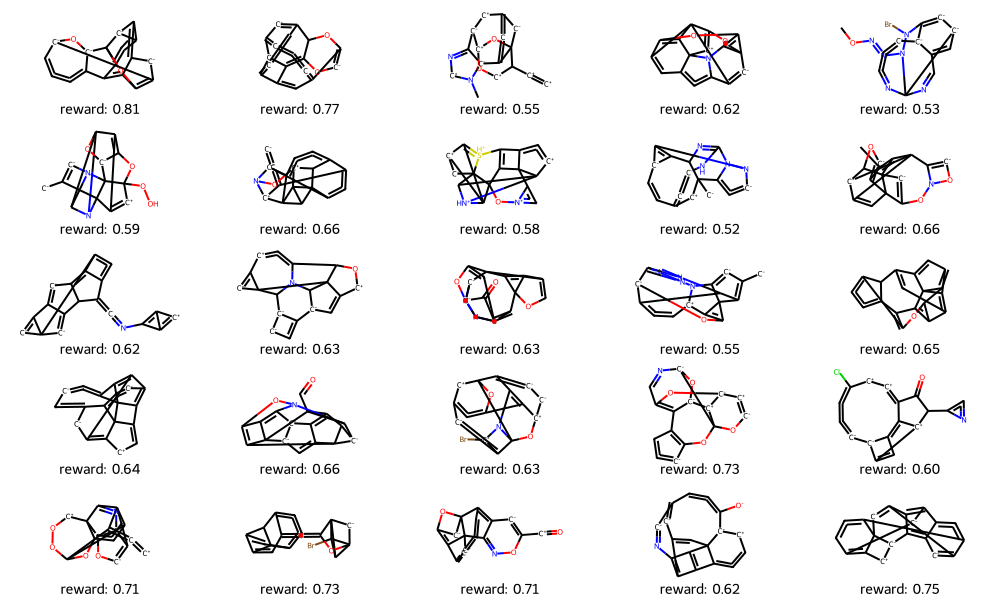

In [12]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

In [1]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(2, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
ax[3].plot([i.value for i in ea.Scalars('online_loss')])
ax[3].set_ylabel('Online loss')
ax[4].plot([i.value for i in ea.Scalars('online_loss')])
ax[4].set_ylabel('Offline loss')
pp.tight_layout()

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'config' is not defined